In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

In [2]:
import matplotlib as plt

In [3]:
import spatialdm as sdm
import spatialdm.plottings as pl

In [4]:
import squidpy as sq

/home/dbdimitrov/anaconda3/lib/python3.8/site-packages/paramiko/transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [5]:
# load the pre-processed dataset
img = sq.datasets.visium_hne_image()
adata = sq.datasets.visium_hne_adata()


  0%|          | 0/1000 [00:00<?, ?/s]

/home/dbdimitrov/.local/lib/python3.8/site-packages/squidpy/pl/_graph.py:239: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  ad = AnnData(X=array, obs={cluster_key: pd.Categorical(adata.obs[cluster_key].cat.categories)})


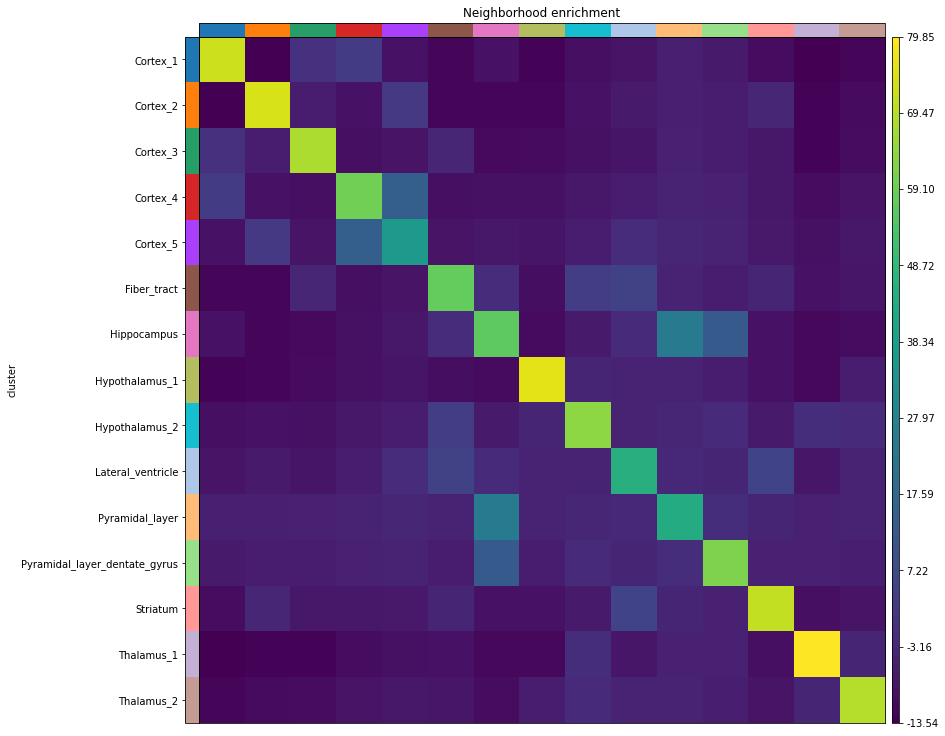

In [6]:
sq.gr.spatial_neighbors(adata)
sq.gr.nhood_enrichment(adata, cluster_key="cluster")
sq.pl.nhood_enrichment(adata, cluster_key="cluster")

Set up

In [7]:
## SpatialDM tutorial data
# adata = sdm.datasets.melanoma()
# raw = pd.DataFrame(adata.raw.X, index=adata.obs_names, columns=adata.raw.var_names)
# log = pd.DataFrame(adata.X, index=adata.obs_names, columns=adata.var_names)

In [8]:
raw = pd.DataFrame(adata.raw.X.todense(), index=adata.obs_names, columns=adata.raw.var_names)
log = pd.DataFrame(adata.X.todense(), index=adata.obs_names, columns=adata.var_names)

In [9]:
spatialcoord = pd.DataFrame(adata.obsm['spatial'], index=adata.obs_names, columns=['x','y'])

In [10]:
# Preprocessing
my_sample = sdm.SpatialDM(log, raw, spatialcoord)     # load spatial data with simply log, raw, spatial input

In [11]:
my_sample.extract_lr(species='mouse', min_cell=3)

We set radial basis kernel parameter l = 1.2, and trimmed all weights < 0.2 (cutoff) to match the normal range of CCC (200 micrometers, 1 spot away from the sender cell here)

In [12]:
?my_sample.weight_matrix

Signature:
my_sample.weight_matrix(
    l,
    cutoff=None,
    n_neighbors=None,
    single_cell=False,
)
Docstring:
compute weight matrix based on radial basis kernel.
cutoff & n_neighbors are two alternative options to         make the matrix sparse
:param l: radial basis kernel parameter, need to be customized to restrain the range of signaling
 before downstream processing.
:param cutoff: minimum weight to be kept from the rbf weight matrix. Weight below cutoff will be made zero
:param n_neighbors: number of neighbors per spot from the rbf weight matrix.
Non-neighbors will be made 0
:param single_cell: if single cell resolution, diagonal will be made 0.
:return: rbf_d weight matrix in obj attribute
File:      ~/anaconda3/lib/python3.8/site-packages/spatialdm/main.py
Type:      method


In [33]:
my_sample.weight_matrix(l=100, cutoff=0.2, single_cell=False)  # Not single-cell resolution

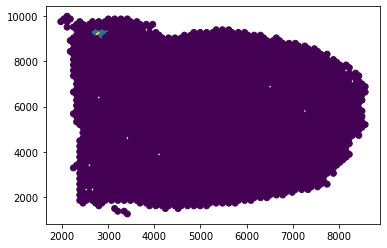

In [34]:
import matplotlib.pyplot as plt
plt.scatter(my_sample.spatialcoord.x, my_sample.spatialcoord.y, c=my_sample.rbf_d[50])

Global Moran's I

In [15]:
# Global selection of significant pairs
my_sample.spatialdm_global(1000, method='both', select_num=None)  # complete in seconds
my_sample.sig_pairs(method='permutation', fdr=True, threshold=0.1)     # select significant pairs

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f9fbc5b9c10>
Traceback (most recent call last):
  File "/home/dbdimitrov/.local/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/dbdimitrov/.local/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/dbdimitrov/.local/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/dbdimitrov/.local/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
100%|██████████| 1000/1000 [01:00<00:00, 16.50it/s]


Moran's global I per LR across the slide

In [16]:
res = my_sample.global_res

In [17]:
res['global_I'] = my_sample.global_I

In [18]:
res[res.index.str.contains('SEMA4D_PLXNB3')][res.global_I > 0.3].sort_values(by='global_I')

<ipython-input-18-384c796ce143>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  res[res.index.str.contains('SEMA4D_PLXNB3')][res.global_I > 0.3].sort_values(by='global_I')


,ligand,receptor,z_pval,perm_pval,fdr,selected,global_I
SEMA4D_PLXNB3,[Sema4d],[Plxnb3],1.360399e-303,0.0,0.0,True,0.311747


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


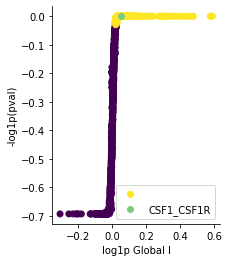

In [19]:
pl.global_plot(my_sample, pairs=['CSF1_CSF1R'])  # Overview of global selection

Re-implement Moran's Global I

1. DataFrame /w L & R 
2. Calulcate L & R means & props (accounting for complexes)
3. Re-implement radial kernel weight
4. Moran's R
5. p-val /w Permutations
6. z-score pvals

In [20]:
adata

AnnData object with n_obs × n_vars = 2688 × 18078
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'leiden', 'cluster'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cluster_colors', 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'spatial', 'umap', 'spatial_neighbors', 'cluster_nhood_enrichment'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

In [21]:
from liana.method._pipe_utils._pre import prep_check_adata
from liana.resource import select_resource, explode_complexes

In [22]:
from liana.method._pipe_utils import prep_check_adata, filter_resource

In [23]:
from liana.method._liana_pipe import filter_reassemble_complexes

In [24]:
_key_cols = ['ligand_complex', 'receptor_complex']

In [25]:
adata = prep_check_adata(adata, groupby='cluster', min_cells=3)

In [26]:
resource = select_resource('MouseConsensus')

Process Resource

In [27]:
resource = explode_complexes(resource)

In [28]:
resource = filter_resource(resource, adata.var_names)

In [29]:
resource

,interaction,ligand,receptor,ligand_complex,receptor_complex
0,Dll1|Notch1,Dll1,Notch1,Dll1,Notch1
1,Dll1|Notch2,Dll1,Notch2,Dll1,Notch2
2,Dll1|Notch4,Dll1,Notch4,Dll1,Notch4
3,Dll1|Notch3,Dll1,Notch3,Dll1,Notch3
4,Nrg2|Erbb2_Erbb3,Nrg2,Erbb2,Nrg2,Erbb2_Erbb3
...,...,...,...,...,...
5070,Saa2|Grm7,Saa2,Grm7,Saa2,Grm7
5073,Saa1|Scarb1,Saa1,Scarb1,Saa1,Scarb1
5074,Saa2|Scarb1,Saa2,Scarb1,Saa2,Scarb1
5075,Saa1|Tlr2,Saa1,Tlr2,Saa1,Tlr2


Get slide means

In [94]:
entities = np.union1d(np.unique(resource["ligand"]),
                      np.unique(resource["receptor"]))

In [95]:
# Filter to only include the relevant genes
adata = adata[:, np.intersect1d(entities, adata.var.index)]

In [96]:
lr_stats = pd.DataFrame({'means': adata.X.mean(axis=0).A.flatten(), 
                        'props': adata.X.getnnz(axis=0) / adata.X.shape[0]},
                        index=adata.var_names).reset_index().rename(columns={'index': 'gene'})

In [97]:
def _rename_means(lr_stats, entity):
    df = lr_stats.copy()
    df.columns = df.columns.map(lambda x: entity + '_' + str(x) if x!='gene' else 'gene')
    return df.rename(columns = {'gene':entity})

In [98]:
lr_res = resource.merge(_rename_means(lr_stats, entity='ligand')).merge(_rename_means(lr_stats, entity='receptor'))

In [99]:
# # Filter non-expressed
# lr_res = lr_res[(lr_res.ligand_props > 0.05) & (lr_res.receptor_props > 0.05)]

Recomplexify

In [101]:
lr_res = filter_reassemble_complexes(lr_res=lr_res,
                                       _key_cols=_key_cols,
                                       expr_prop=0.05,
                                       complex_cols=['ligand_means', 'receptor_means'])

In [102]:
lr_res[lr_res.interaction.str.contains('Plxnb3')]

,interaction,ligand,receptor,ligand_complex,receptor_complex,ligand_means,ligand_props,receptor_means,receptor_props,prop_min
1221,Sema5a|Plxnb3,Sema5a,Plxnb3,Sema5a,Plxnb3,0.418452,0.452009,0.190867,0.219866,0.219866
1222,Sema4d|Plxnb3,Sema4d,Plxnb3,Sema4d,Plxnb3,0.544131,0.524554,0.190867,0.219866,0.219866
1223,Sema4a|Plxnb3,Sema4a,Plxnb3,Sema4a,Plxnb3,0.296781,0.383557,0.190867,0.219866,0.219866


For now I will use their spatial kernel weights

In [ ]:
rbf_d = my_sample.rbf_d

In [ ]:
# every spot to every spot:
my_sample.rbf_d.shape[0]

For one LR at a time:

In [ ]:
# whole slide mean
ligand_mean = 0.544131 # np.full(my_sample.rbf_d.shape[0], 0.544131)
receptor_mean = 0.190867 # np.full(my_sample.rbf_d.shape[0], 0.190867)

get log expr per spot & normlalize

In [ ]:
ligand_expr = adata[:,adata.var_names=="Sema4d"].X.A - ligand_mean
receptor_expr = adata[:,adata.var_names=="Plxnb3"].X.A - receptor_mean

In [ ]:
global_I = np.sum(rbf_d @ ligand_expr * receptor_expr) / ((sum(ligand_expr ** 2) * sum(receptor_expr ** 2)) ** (1 / 2))

In [ ]:
global_I

In [ ]:
numerator = rbf_d @ ligand_expr * receptor_expr

In [ ]:
numerator.shape

In [ ]:
denominator = (sum(ligand_expr ** 2) * sum(receptor_expr ** 2)) ** (1 / 2)

In [ ]:
denominator

In [ ]:
np.sum(numerator) / denominator

In [ ]:
np.sum(global_I)

(Vectorized) For all interactions:

norm expr mat - i.e. (x - x^) & (y - y^)

In [ ]:
norm_mat = np.array(adata.X -  adata.X.mean(axis=0))
sqrt_a = np.sqrt(np.sum(np.power(norm_mat, 2), axis=0)).T

In [ ]:
ligand_pos = {entity: np.where(adata.var_names == entity)[0][0] for entity
              in lr_res['ligand']}
receptor_pos = {entity: np.where(adata.var_names == entity)[0][0] for entity
                in lr_res['receptor']}

Tensor:

Spots, Ligand_exp, Receptor_exp

Calculate Moran's I

In [ ]:
def _morans_global(x, ligand_pos, receptor_pos, norm_mat, sqrt_a, rbf_d):
    
    lpos = ligand_pos[x.ligand]
    rpos = receptor_pos[x.receptor]
    
    global_R = (norm_mat[:,lpos].T @ rbf_d) @ norm_mat[:,rpos] / (sqrt_a[lpos]*sqrt_a[rpos])
    
    return global_R

In [ ]:
lr_res['global_R'] =  lr_res.apply(
    _morans_global,
    axis=1,
    result_type="expand",
    ligand_pos=ligand_pos,
    receptor_pos=receptor_pos, 
    norm_mat=norm_mat,
    sqrt_a=sqrt_a,
    rbf_d=rbf_d)

In [ ]:
lr_res.sort_values('global_R')

In [ ]:
import matplotlib

In [ ]:
matplotlib.pyplot.hist(lr_res['global_R'].values)

In [ ]:
lpos = ligand_pos['Sema4d']
rpos = receptor_pos['Plxnb3']

In [ ]:
x = ((norm_mat[:,lpos].T @ rbf_d) * norm_mat[:,rpos])/(sqrt_a[lpos]*sqrt_a[rpos])

In [ ]:
(norm_mat[lpos].A * norm_mat[rpos].A)

In [ ]:
norm_mat

In [ ]:
(sqrt_a[lpos]*sqrt_a[rpos])

In [ ]:
norm_mat[lpos].shape

In [ ]:
norm_mat[lpos].A 

In [ ]:
lr_res.ligand_expr[lpos]

In [ ]:
receptor_expr

In [ ]:
lr_res.loc[2680:2700]

In [ ]:
my_sample.local_I_R.shape

Local Moran's I

In [ ]:
# Local selection of significant spots
my_sample.spatialdm_local(n_perm=100, method='both', select_num=None, nproc=1)     # local spot selection complete in seconds

In [ ]:
my_sample.sig_spots(method='permutation', fdr=True, threshold=0.05)     # significant local spots

In [ ]:
my_sample.local_I.shape

In [ ]:
pl.plot_pairs(my_sample, ['CSF1_CSF1R'], marker='s') # visualize known melanoma pair(s)